# 01/22/2024 - This notebook tests additions to slacs_kcwi_kineamtics.py

##### 01/09/24 - continuuing from yesterday

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pathlib # to create directory
import dill as pickle
from datetime import datetime
import os

from ppxf.ppxf import ppxf
from pathlib import Path
from scipy import ndimage
from urllib import request
from scipy import ndimage
from time import perf_counter as clock
from scipy import interpolate
from astropy.visualization import simple_norm
from astropy.modeling.models import Sersic2D
import astropy.units as u
from vorbin.voronoi_2d_binning import voronoi_2d_binning


# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages/ppxf_kcwi_util_022423")

from slacs_kcwi_kinematics import slacs_kcwi_kinematics

In [2]:
#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

In [3]:
# Universal parameters
# todays date
date = datetime.now().strftime("%Y_%m_%d")
# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
kinematics_dir = f'{data_dir}kinematics/{date}/'
if not os.path.exists(kinematics_dir):
    os.mkdir(kinematics_dir)
#------------------------------------------------------------------------------
# Kinematics systematics initial choices
# aperture
aperture = 'R2'
# wavelength range
wave_min = 3400
wave_max = 4300 ########### NOTE J0330 will be different
# degree of the additive Legendre polynomial in ppxf
degree = 4 # 900/250 = 3.6 round up
#------------------------------------------------------------------------------
# Information specific to KCWI and templates
kcwi_scale = 0.1457
## R=3600. spectral resolution is ~ 1.42A
FWHM = 1.42 #1.42
## initial estimate of the noise
noise = 0.014
# velocity scale ratio
velscale_ratio = 2
#------------------------------------------------------------------------------
# variable settings in ppxf and utility functions
# cut the datacube at lens center, radius given here
radius_in_pixels = 21
# target SN for voronoi binning
#vorbin_SN_targets = np.array([10, 15, 20])
bin_target_SN = 15.
# minimum SN of pixels to be included in voronoi bining
pixel_min_SN = 1.
# stellar population
sps_name = 'emiles'


__________
# J0029

In [4]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ0029-0055'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.227 # lens redshift
T_exp = 1800*5 # exposure time in seconds... this is where I made the disastrous mistake
lens_center_x,lens_center_y = 61, 129
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'

mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


In [5]:
j0029_kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             bin_target_SN=bin_target_SN,
                                             pixel_min_SN=pixel_min_SN,
                                             plot=True,
                                             quiet=False
)

In [6]:
f'{os.getcwd()}/data/'

'/home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/kinematics_extraction/data/'

In [7]:
j0029_kinematics.print_function_order()


# convenience function will do all the below automatically
#j0029_kinematics.run_slacs_kcwi_kinematics()
# Visualize the summed datacube
j0029_kinematics.datacube_visualization()
# rebin the central spectrum in log wavelengths and prepare for fitting
j0029_kinematics.log_rebin_central_spectrum()
# same with background spectrum
j0029_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
j0029_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
j0029_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
j0029_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
j0029_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
j0029_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
j0029_kinematics.select_region()
# bin the selected spaxels to the target S/N
j0029_kinematics.voronoi_binning()
# fit each bin spectrum with g

 Best Fit:       Vel     sigma
 comp.  0:       108       223
chi2/DOF: 0.1793; DOF: 1969; degree = 4; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/151


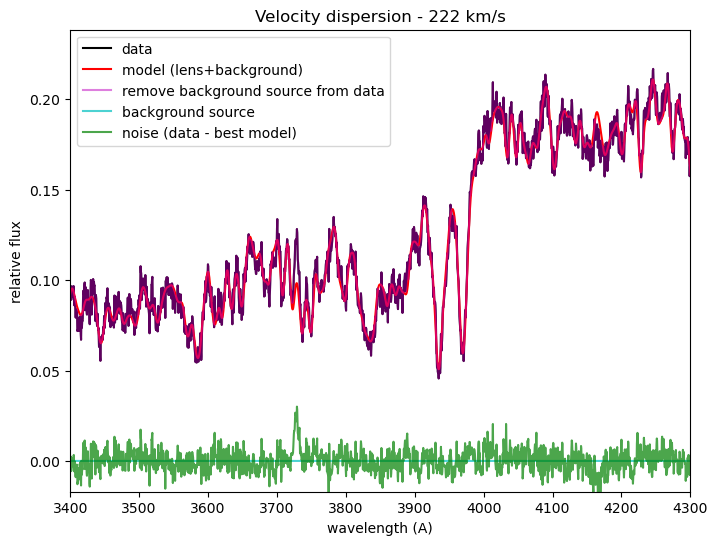

Formal errors:
     dV    dsigma   dh3      dh4
     3.6     3.9
Elapsed time in pPXF: 3.34 s


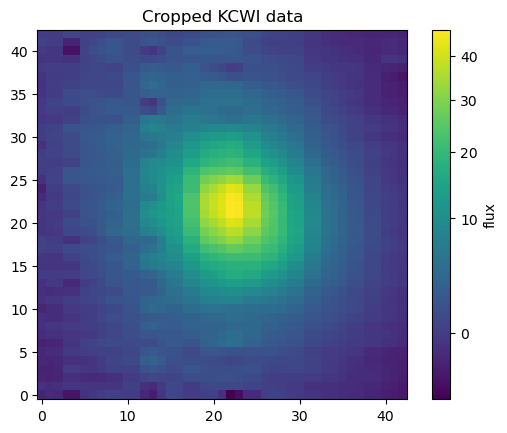

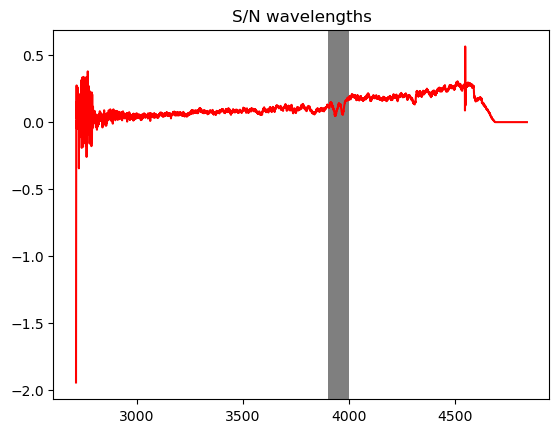

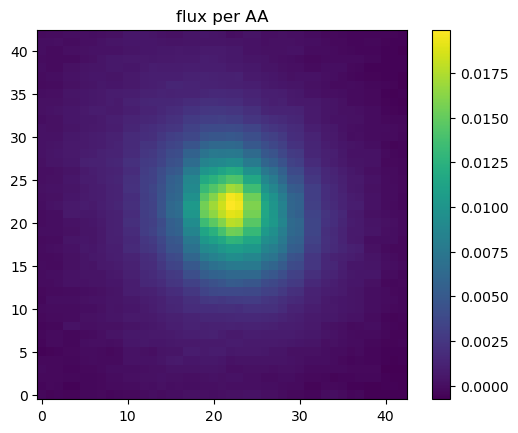

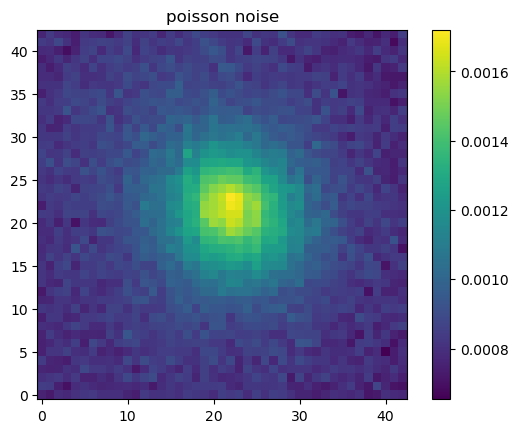

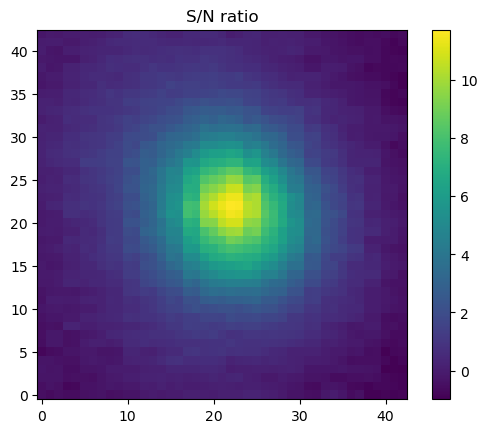

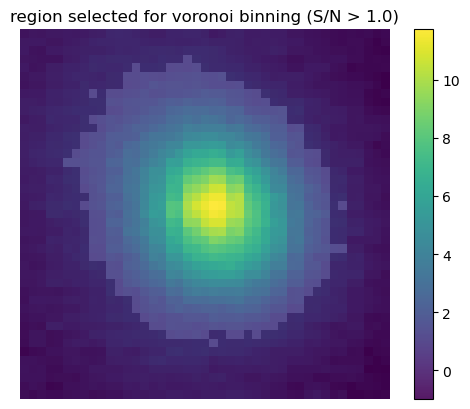

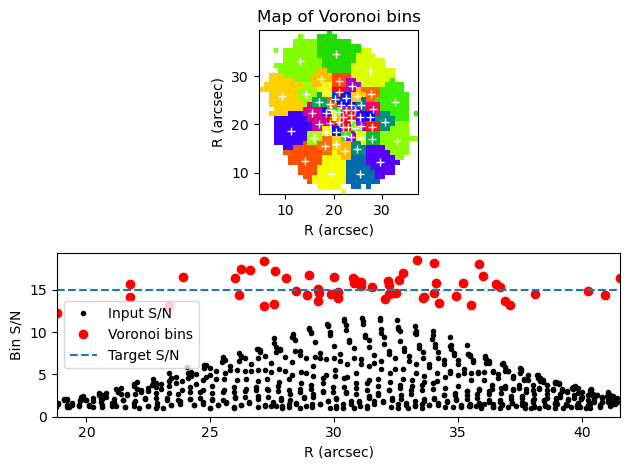

Number of bins = 59


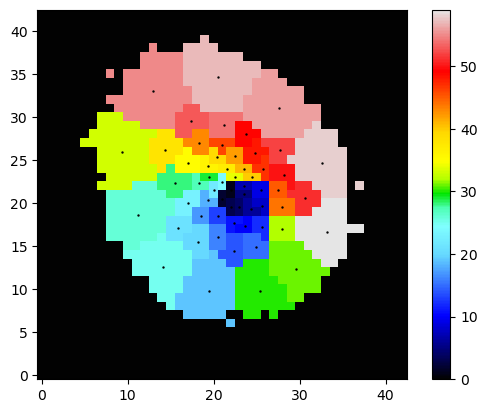

In [8]:
# rebin the central spectrum in log wavelengths and prepare for fitting
j0029_kinematics.log_rebin_central_spectrum()
# same with background spectrum
j0029_kinematics.log_rebin_background_spectrum()
# prepare the templates from the sps model
j0029_kinematics.get_templates()
# set up the wavelengths that will be fit, masks a couple gas lines
j0029_kinematics.set_up_mask()
# fit the central spectrum to create the global_template
j0029_kinematics.ppxf_central_spectrum()
# crop the datacube to a smaller size
j0029_kinematics.crop_datacube()
# create a S/N map to get the Voronoi binning going
j0029_kinematics.create_SN_map()
# select the spaxels S/N > 1 that will be binned
j0029_kinematics.select_region()
# bin the selected spaxels to the target S/N
j0029_kinematics.voronoi_binning()

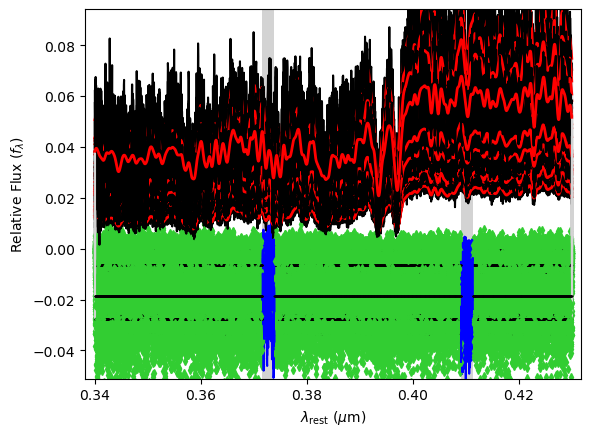

In [9]:
j0029_kinematics.ppxf_bin_spectra(fit_poisson_noise=True)

# Need to bring in the utility functions from the module

In [18]:
import ppxf.ppxf_util as ppxf_util

def poisson_noise(T_exp, gal_lin, std_bk_noise, per_second=False):
    '''
    This means that the pixel uncertainty of pixel i (sigma_i) is obtained
    from the science image intensity pixel i (d_i) by:
    sigma_i^2 = scale * (d_i)^power + const
    The first term represents noise from the astrophysical source, and the
    second term is background noise (including read noise etc.).
    When power=1 and scale=1 with d_i in counts, the astrophysical source noise
    (=1*d_i^1=d_i) is Poisson. Suyu 2012 and Suyu et al. 2013a have somels

    description of this.

    To construct the weight map using the esource_noise_model:
    -- set power=1
    -- obtain const by estimating the variance of the background (i.e., const = sigma_bkgd^2 from an empty part of of the science image).
    -- the scale is 1 if d_i is in counts, but otherwise it needs to account for exposure time if d_i is in counts per second.

    Since the unit of the KCWI data is flux/AA (see fits header),
    I need to compute scale with appropriate multiplications/divisions of
    the exposure time (T_exp).  In this case, scale should be 1/texp so that
    the units are in counts/sec for sigma_i^2 (since d_i needs to be
    multiplied by texp to get to counts for Poisson noise estimation,
    but then divided by texp^2 to get to counts/sec).

    :param T_exp: the total exposure time of the dataset
    :param gal_lin: input data
    :param bk_noise: standard deviation of the background noise
    :param per_second: set True if it is in the unit of counts/second
    :return: poisson noise
    '''

    const = std_bk_noise**2
    if per_second:
        scale= 1/T_exp
        sigma2 = scale * (gal_lin) + const
    else:
        scale = 1.
        sigma2 = scale * (gal_lin) + const

    if (sigma2<0).any():
        sigma2[sigma2 < 0] = const

    if np.isnan(sigma2).any():
        sigma2[np.isnan(sigma2)] = const

    poisson_noise = np.sqrt(sigma2)

    return poisson_noise

def find_nearest(array, value):
    '''
    :param array: wavelength array
    :param value: wavelength that we want to get the index
    :return: the index of the wavelength
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def de_log_rebin(delog_axi, value, lin_axi):
    '''
    :param delog_axi: input the value by np.exp(logLam1)
    :param value: flux at the location of np.exp(logLam1) array
    :param lin_axi: linear space in wavelength that we want to intepolate
    :return: flux at the location of linear space in wavelength
    '''
    inte_sky = interpolate.interp1d(delog_axi, value, bounds_error=False)
    sky_lin = inte_sky(lin_axi)
    return sky_lin


c = 299792.458 # km/s

In [19]:
def ppxf_bin_spectra_test(self, fit_poisson_noise=True, plot_bin_fits=True):
        '''
        Function to loop through bin spectra constructed with "voronoi_binning" function. Fit each spectrum with ppxf using "global_template" constructed during the "ppxf_central_spectrum" function.
        
        Optional keywords:
        
        fit_poisson_noise - not working in this code yet, but if True a better noise contribution after assuming a uniform noise across all wavelengths
        
        plot_bin_fits - if True, each bin fit will be plotted with bin number and velocity dispersion measurement. Takes quite a bit more time, but is recommended.
        '''
        
        # bin_kinematics will be an array of five entries (mean velocity, velocity dispersion, errors on both, and chi2 value)
        self.bin_kinematics = np.zeros(shape=(0,5))
        
        # loop through nbins
        for i in range(1):#(self.nbins):
            
            # take the bin spectrum (data)
            bin_spectrum = self.voronoi_binning_data[i]
            
            # rebin the spectrum with restframe wavelengths in log space, "galaxy" is now the data to be fit
            galaxy, log_wavelengths, velscale = ppxf_util.log_rebin(self.rest_wave_range, bin_spectrum)
            
            # take the wavelengths of the data
            wavelengths = np.exp(log_wavelengths)
            
            # cut the data, background source, and wavelengths to the wave_min and wave_max we specified
            galaxy = galaxy[wavelengths>self.wave_min]
            background_source = self.background_spectrum.copy()
            background_source = background_source[wavelengths>self.wave_min]
            wavelengths = wavelengths[wavelengths>self.wave_min]
            galaxy = galaxy[wavelengths<self.wave_max]
            background_source = background_source[wavelengths<self.wave_max]
            wavelengths = wavelengths[wavelengths<self.wave_max]
            
            # take the log of the now-cut wavelength array
            log_wavelengths = np.log(wavelengths)
            
            # take the wavelength range of the global template
            lam_range_global_temp = np.array([self.global_template_wave.min(), self.global_template_wave.max()])
            
            # keep only the good pixels, after de-redshift, the initial redshift is zero.
            goodPixels = ppxf_util.determine_goodpixels(log_wavelengths, lam_range_global_temp, 0)
            
            # find the indices of wave_min and wave_max in wavelengths array
            ind_min = find_nearest(wavelengths, self.wave_min)
            ind_max = find_nearest(wavelengths, self.wave_max)
            
            # mask the appropriate wavelengths and gas emission lines
            mask=goodPixels[goodPixels<ind_max]
            mask = mask[mask>ind_min]
            boolen = ~((2956 < mask) & (mask < 2983))  # mask the Mg II
            mask = mask[boolen]
            boolen = ~((2983 < mask) & (mask < 3001))  # mask the Mg II
            mask = mask[boolen]
            
            # setup with initial guesses
            vel = c*np.log(1 + 0)   # eq.(8) of Cappellari (2017)
            start = [vel, 250.]  # (km/s), starting guess for [V, sigma]
            #bounds = [[-500, 500],[50, 450]] # not necessary
            t = clock()
            
            # set the initial noise as uniform across wavelengths from input noise estimate
            noise = np.full_like(galaxy, self.noise)
            
            # fit the bin spectrum with the global template using ppxf
            pp = ppxf(self.global_template, # global template created in "ppxf_central_spectrum" function
                      galaxy, # bin spectrum (data)
                      noise, # noise estimate
                      velscale, # velocity scale of data (resolution)
                      start, # initial guess
                      sky=background_source, # background source spectrum 
                      plot=False, # we plot later 
                      quiet=self.quiet, # suppress the outputs
                        moments=2, # fit only mean velocity and velocity dispersion
                      goodpixels=mask, # mask of wavelengths 
                        degree=self.degree, # degree of additive polynomial for fitting
                        velscale_ratio=self.velscale_ratio, # resolution ratio of data vs template
                        lam=wavelengths, # wavelengths in restframe of data
                        lam_temp=self.global_template_wave, # wavelenghts in restframe of the global template
                        )
            
            # Do another fit using the noise from the previous fit to make a better estimate of the Poisson noise
            if fit_poisson_noise==True:
                
                # take the outputs of the previous fit
                data = pp.galaxy
                model = pp.bestfit
                log_axis = wavelengths
                
                # make linear axis of wavelengths and rebin data and model to linear axis
                lin_axis = np.linspace(self.wave_min, self.wave_max, data.size)
                data_lin = de_log_rebin(log_axis, data, lin_axis)
                model_lin = de_log_rebin(log_axis, model, lin_axis)
                # get the noise as the residual between data and model
                noise_lin = data_lin - model_lin
                
                # estimate poisson noise
                noise_poisson = poisson_noise(self.exp_time, 
                                                   model_lin,
                                                   np.nanstd(noise_lin[ind_min:ind_max]),
                                                   per_second=True
                                                  )
                
                # fit again with the better noise estimate
                pp = ppxf(self.global_template, 
                          galaxy, 
                          noise_poisson, 
                          velscale, 
                          start, 
                          sky=background_source, 
                          plot=True,#plot_bin_fits, 
                          quiet=self.quiet,
                            moments=2, 
                          goodpixels=mask,
                            degree=self.degree,
                            velscale_ratio=self.velscale_ratio,
                            lam=wavelengths,
                            lam_temp=self.global_template_wave,
                            )
            
            # for viewing each bin spectrum fit
            if plot_bin_fits==True:
                
                # take the background source, data, model
                background = background_source * pp.weights[-1]
                data = pp.galaxy
                model = pp.bestfit
                log_axis = wavelengths
                
                # rebin on linear axis
                lin_axis = np.linspace(self.wave_min, self.wave_max, data.size)
                back_lin = de_log_rebin(log_axis, background, lin_axis)
                model_lin = de_log_rebin(log_axis, model, lin_axis)
                data_lin = de_log_rebin(log_axis, data, lin_axis)
                # take noise as residual
                noise_lin = data_lin - model_lin
                
                # find the indices of the restframe wavelengths that are closest to the min and max we want for plot limits
                plot_ind_min = find_nearest(lin_axis, self.wave_min)
                plot_ind_max = find_nearest(lin_axis, self.wave_max)
                
                # make the figure
                plt.figure(figsize=(8,6))
                
                # plot data, model, background-subtracted data, and residual
                plt.plot(lin_axis, data_lin, 'k-', label='data')
                plt.plot(lin_axis, model_lin, 'r-', label='model ('
                                                             'lens+background)')
                plt.plot(lin_axis, data_lin - back_lin, 'm-',
                         label='remove background source from data', alpha=0.5)
                plt.plot(lin_axis, back_lin + np.full_like(back_lin, 0.9e-5), 'c-',label='background source', alpha=0.7)
                plt.plot(lin_axis, noise_lin + np.full_like(back_lin, 0.9e-5), 'g-',
                         label='noise (data - best model)', alpha=0.7)
                
                # set up axis, etc.
                plt.legend(loc='best')
                plt.ylim(np.nanmin(noise_lin[plot_ind_min:plot_ind_max])/1.1, np.nanmax(data_lin[plot_ind_min:plot_ind_max])*1.1)
                plt.xlim(self.wave_min, self.wave_max)
                plt.xlabel('wavelength (A)')
                plt.ylabel('relative flux')
                plt.title(f'Bin {i} - Velocity dispersion - {int(pp.sol[1])} km/s')
                plt.show()
                plt.pause(1)
                
            # save the kinematics and initial error estimates, as well as chi2 (V, VD, dV, dVD, chi2)
            # pp.error is formal error from ppxf; if fit is reliable, can be corrected with chi2 as shown below
            # ideally, we want to be able to instead sample the velocity space for more reliable error estimate
            self.bin_kinematics = np.vstack(
                                            (
                                                self.bin_kinematics, 
                                                 np.hstack( 
                                                             (
                                                                 pp.sol[:2],
                                                                 (pp.error*np.sqrt(pp.chi2))[:2],
                                                                 pp.chi2) 
                                                              )
                                             )
                                            )

In [20]:
from types import MethodType

#j0029_kinematics.ppxf_bin_spectra_test = MethodType(ppxf_bin_spectra_test, j0029_kinematics)


In [21]:
#j0029_kinematics.ppxf_bin_spectra_test()

#print(j0029_kinematics.bin_kinematics)

______________________________________________

# Now let's look at the error sampling

In [22]:
import emcee
from adamet.corner_plot import corner_plot


In [ ]:
# take the bin spectrum from voronoi binning
bin_spectrum = self.voronoi_binning_data[i]
#normalize
bin_spectrum = bin_spectrum/np.nanmedian(bin_spectrum)

# rebin in log space
galaxy, log_wavelengths, velscale = ppxf_util.log_rebin(self.rest_wave_range, bin_spectrum)
wavelengths = np.exp(log_wavelengths)

# crop the galaxy spectrum to the size we care about
galaxy = galaxy[wavelengths>self.wave_min] 
wavelengths = wavelengths[wavelengths>self.wave_min]
galaxy = galaxy[wavelengths<self.wave_max]
# these are the wavelengths we fit
wavelengths = wavelengths[wavelengths<self.wave_max]
log_wavelengths = np.log(wavelengths)

# get the wavelength range of the global template
lam_range_global_temp = np.array([self.global_template_wave.min(), self.global_template_wave.max()])

goodPixels = ppxf_util.determine_goodpixels(log_wavelengths, lam_range_global_temp, 0)

# get indices for the nearest of wave_min and wave_max
ind_min = find_nearest(wavelengths, self.wave_min)
ind_max = find_nearest(wavelengths, self.wave_max)
# keep in range wave_min, wave_max
mask=goodPixels[goodPixels<ind_max]
mask = mask[mask>ind_min]
# mask gas emission
boolen = ~((2956 < mask) & (mask < 2983))  # mask the Mg II
mask = mask[boolen]
boolen = ~((2983 < mask) & (mask < 3001))  # mask the Mg II
mask = mask[boolen]

# starting guess, etc
vel = c*np.log(1 + 0)   # eq.(8) of Cappellari (2017)
start = [vel, 250.]  # (km/s), starting guess for [V, sigma]
t = clock()

# some initial noise guess
noise = np.full_like(galaxy, 0.0047)

pp = ppxf(self.global_template, 
      galaxy, 
      noise, 
      velscale, 
      start, 
      sky=background_source, 
      plot=False,#plot_bin_fits, 
      quiet=self.quiet,
      moments=2, 
      goodpixels=mask,
      degree=self.degree,
      velscale_ratio=self.velscale_ratio,
      lam=wavelengths,
      lam_temp=self.global_template_wave,
    )


print('Doing the emcee error sampling')
# Do the fit
def ppxf_function(parameters, bounds):
    if any(parameters < bounds[0]) or any(parameters > bounds[1]):
        lnprob = -np.inf
        return lnprob
    else:
        pp_ = ppxf(self.global_template, #global_template_fixed_poly, # add the additive polynomial to the template and fit ONLY the kinematics
                  galaxy, 
                  noise,
                  velscale, 
                  sky=pp.apoly, 
                  fixed=[1,1],
                  start=parameters, 
                  plot=False,
                  moments=[-2], 
                  goodpixels=mask,
                  degree=-1,#self.degree, # additive polynomial was added to the global template instead, so it is not refit
                  velscale_ratio=self.velscale_ratio,
                  lam=wavelengths,
                  lam_temp=self.global_template_wave,
                  quiet=True
                  )
        #print(pp_.sol)
        #plt.title(f'{parameters}')
        #plt.pause(1)
        plt.clf()
        chi2 = np.nansum((pp_.galaxy-pp_.bestfit)**2)/pp_.dof
        #print('velocities', parameters)
        #print('chi2', chi2)
        #print('#################')
        lnprob = -0.5*chi2
        return lnprob
print("Started Emcee please wait...")
print("Progress is printed periodically")
nstep, nwalkers, ndim = 1000, 16, 2#self.sampler_args
bounds = [[pp.sol[0]-50, pp.sol[1]-50],
          [pp.sol[0]+50, pp.sol[1]+50]]
print('bounds',bounds)
# set initial walker positions
initial_state = np.random.uniform(bounds[0], bounds[1], [nwalkers,ndim])
sampler = emcee.EnsembleSampler(nwalkers, ndim, ppxf_function, kwargs={'bounds':bounds}) # Unsure about this one
sampler.run_mcmc(initial_state, nstep, progress=True)
self.pars = sampler.get_chain(flat=True)
self.lnprobs = sampler.get_log_prob(flat=True)
#print('pars',self.pars)
#print('lnprobs',self.lnprobs)
bestfit = self.pars[np.nanargmax(self.lnprobs)]
# calculate uncertainties in posterior
perc = np.percentile(self.pars, [15.86, 84.14], axis=0)  # 68% interval
sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)
# For plotting, only show the finite probability points
finite = np.isfinite(self.lnprobs)
# Produce final corner plot without trial values and with best fitting JAM
plt.rcParams.update({'font.size': 14})
plt.clf()
corner_plot(self.pars[finite], self.lnprobs[finite]/np.nanmax(self.lnprobs), fignum=1)
plt.gcf()
plt.title(f'{bestfit} +- {sig_bestfit}')
plt.xlabel('V')
plt.ylabel(r'$\sigma$')
print('best fit', bestfit)
print('error', sig_bestfit)

In [32]:
def ppxf_bin_spectra_test2(self, plot_bin_fits=False):
    self.bin_kinematics = np.zeros(shape=(0,5))
    for i in range(self.nbins):
        bin_spectrum = self.voronoi_binning_data[i]
        bin_spectrum = bin_spectrum/np.nanmedian(bin_spectrum)

        galaxy, log_wavelengths, velscale = ppxf_util.log_rebin(self.rest_wave_range, bin_spectrum)
        wavelengths = np.exp(log_wavelengths)

        galaxy = galaxy[wavelengths>self.wave_min] 
        background_source = self.background_spectrum.copy()
        background_source = background_source[wavelengths>self.wave_min]
        wavelengths = wavelengths[wavelengths>self.wave_min]
        galaxy = galaxy[wavelengths<self.wave_max]
        background_source = background_source[wavelengths<self.wave_max]
        wavelengths = wavelengths[wavelengths<self.wave_max]
        log_wavelengths = np.log(wavelengths)

        lam_range_global_temp = np.array([self.global_template_wave.min(), self.global_template_wave.max()])
        # after de-redshift, the initial redshift is zero.
        goodPixels = ppxf_util.determine_goodpixels(log_wavelengths, lam_range_global_temp, 0)

        ind_min = find_nearest(wavelengths, self.wave_min)
        ind_max = find_nearest(wavelengths, self.wave_max)
        mask=goodPixels[goodPixels<ind_max]
        mask = mask[mask>ind_min]
        boolen = ~((2956 < mask) & (mask < 2983))  # mask the Mg II
        mask = mask[boolen]
        boolen = ~((2983 < mask) & (mask < 3001))  # mask the Mg II
        mask = mask[boolen]
        # Here the actual fit starts. The best fit is plotted on the screen.
        # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
        #
        vel = c*np.log(1 + 0)   # eq.(8) of Cappellari (2017)
        start = [vel, 250.]  # (km/s), starting guess for [V, sigma]
        t = clock()

        noise = np.full_like(galaxy, 0.0047)

        pp = ppxf(self.global_template, 
                  galaxy, 
                  noise, 
                  velscale, 
                  start, 
                  sky=background_source, 
                  plot=False,#plot_bin_fits, 
                  quiet=self.quiet,
                  moments=2, 
                  goodpixels=mask,
                  degree=self.degree,
                  velscale_ratio=self.velscale_ratio,
                  lam=wavelengths,
                  lam_temp=self.global_template_wave,
                )
        
        # take the global template and add the additive polynomial
        # pad the polynomial to be the size of the templates
        #ind_min = find_nearest(self.global_template_wave, self.wave_min)
        #ind_max = find_nearest(self.global_template_wave, self.wave_max)
        #print(ind_min, ind_max)
        #pad_lo = np.zeros(ind_min)
        #pad_hi = np.zeros(self.global_template_wave.size - ind_max)
        #print(pad_lo.size, pad_hi.size, pp.apoly.size)
        #poly_padded = np.concatenate(
        #                            (pad_lo, pp.apoly, pad_hi)
         #                           )
        #print(poly_padded.size)
        #global_template_fixed_poly = self.global_template+poly_padded
        
        if i==0:
            #bigbigbug testing sampling the errors
            print('Doing the emcee error sampling')
            # Do the fit
            def ppxf_function(parameters, bounds):
                if any(parameters < bounds[0]) or any(parameters > bounds[1]):
                    lnprob = -np.inf
                    return lnprob
                else:
                    pp_ = ppxf(self.global_template, #global_template_fixed_poly, # add the additive polynomial to the template and fit ONLY the kinematics
                              galaxy, 
                              noise,
                              velscale, 
                              sky=pp.apoly, 
                              fixed=[1,1],
                              start=parameters, 
                              plot=False,
                              moments=[-2], 
                              goodpixels=mask,
                              degree=-1,#self.degree, # additive polynomial was added to the global template instead, so it is not refit
                              velscale_ratio=self.velscale_ratio,
                              lam=wavelengths,
                              lam_temp=self.global_template_wave,
                              quiet=True
                              )
                    #print(pp_.sol)
                    #plt.title(f'{parameters}')
                    #plt.pause(1)
                    plt.clf()
                    chi2 = np.nansum((pp_.galaxy-pp_.bestfit)**2)/pp_.dof
                    #print('velocities', parameters)
                    #print('chi2', chi2)
                    #print('#################')
                    lnprob = -0.5*chi2
                    return lnprob
            print("Started Emcee please wait...")
            print("Progress is printed periodically")
            nstep, nwalkers, ndim = 1000, 16, 2#self.sampler_args
            bounds = [[pp.sol[0]-50, pp.sol[1]-50],
                      [pp.sol[0]+50, pp.sol[1]+50]]
            print('bounds',bounds)
            # set initial walker positions
            initial_state = np.random.uniform(bounds[0], bounds[1], [nwalkers,ndim])
            sampler = emcee.EnsembleSampler(nwalkers, ndim, ppxf_function, kwargs={'bounds':bounds}) # Unsure about this one
            sampler.run_mcmc(initial_state, nstep, progress=True)
            self.pars = sampler.get_chain(flat=True)
            self.lnprobs = sampler.get_log_prob(flat=True)
            #print('pars',self.pars)
            #print('lnprobs',self.lnprobs)
            bestfit = self.pars[np.nanargmax(self.lnprobs)]
            # calculate uncertainties in posterior
            perc = np.percentile(self.pars, [15.86, 84.14], axis=0)  # 68% interval
            sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)
            # For plotting, only show the finite probability points
            finite = np.isfinite(self.lnprobs)
            # Produce final corner plot without trial values and with best fitting JAM
            plt.rcParams.update({'font.size': 14})
            plt.clf()
            corner_plot(self.pars[finite], self.lnprobs[finite]/np.nanmax(self.lnprobs), fignum=1)
            plt.gcf()
            plt.title(f'{bestfit} +- {sig_bestfit}')
            plt.xlabel('V')
            plt.ylabel(r'$\sigma$')
            print('best fit', bestfit)
            print('error', sig_bestfit)
        else:
            break

        if plot_bin_fits==True:
            #plot the fit
            best_sky = background_source * pp.weights[-1]
            gal_lin = pp.galaxy#spectrum_perpixel
            log_axis_sky = wavelengths
            lin_axis_sky = np.linspace(self.wave_min, self.wave_max, gal_lin.size)
            sky_lin = de_log_rebin(log_axis_sky, best_sky, lin_axis_sky)
            best_lin = de_log_rebin(log_axis_sky, pp.bestfit, lin_axis_sky)
            gal_lin = de_log_rebin(log_axis_sky, gal_lin, lin_axis_sky)
            more_noise = gal_lin - best_lin

            plt.figure(figsize=(8,6))
            plt.plot(lin_axis_sky, gal_lin, 'k-', label='data')
            plt.plot(lin_axis_sky, best_lin, 'r-', label='best model ('
                                                         'lens+background)')
            plt.plot(lin_axis_sky, gal_lin - sky_lin, 'm-',
                     label='remove background source from data', alpha=0.5)
            plt.plot(lin_axis_sky, sky_lin + np.full_like(sky_lin, 0.9e-5), 'c-',label='background source', alpha=0.7)
            plt.plot(lin_axis_sky, more_noise + np.full_like(sky_lin, 0.9e-5), 'g-',
                     label='noise (data - best model)', alpha=0.7)
            #if mask_quasar is not None:
            #    for i in range(mask_quasar.shape[1]):
            #        plt.fill_between(mask_quasar[:,i], [0,0], [1,1], color='k', alpha=0.1)
            plt.legend(loc='best')
            #plt.ylim(np.min(more_noise + np.full_like(sky_lin, 0.9e-5)), np.max(gal_lin)*1.01)
            plt.ylim(np.nanmin(more_noise)/1.1, np.nanmax(gal_lin)*1.1)
            plt.xlim(self.wave_min, self.wave_max)#lin_axis_sky.min(), lin_axis_sky.max())
            plt.xlabel('wavelength (A)')
            plt.ylabel('relative flux')
            plt.title(f'Velocity dispersion - {int(pp.sol[1])} km/s')
            plt.show()
            plt.pause(1)
        self.bin_kinematics = np.vstack((self.bin_kinematics, np.hstack( (pp.sol[:2],
                                                       (pp.error*np.sqrt(pp.chi2))[:2],
                                                                  pp.chi2) 
                                                                  )
                                     )
                                    )

(3900.0, 4050.0)

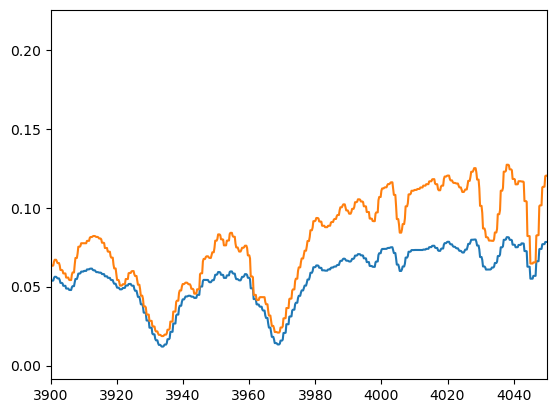

In [28]:
for i, template in enumerate(j0029_kinematics.central_spectrum_ppxf.templates.T):
    weight = j0029_kinematics.central_spectrum_ppxf.weights[i]
    if weight!=0:
        plt.plot(j0029_kinematics.central_spectrum_ppxf.lam_temp, template*weight)
plt.xlim(3900, 4050)


In [29]:
j0029_kinematics.ppxf_bin_spectra_test2 = MethodType(ppxf_bin_spectra_test2, j0029_kinematics)

Doing the emcee error sampling
Started Emcee please wait...
Progress is printed periodically
bounds [[56.837597485217046, 163.82803051738784], [156.83759748521703, 263.82803051738784]]


100%|████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.08it/s]


best fit [106.17684032 210.96248952]
error [34.53178449 33.52990633]


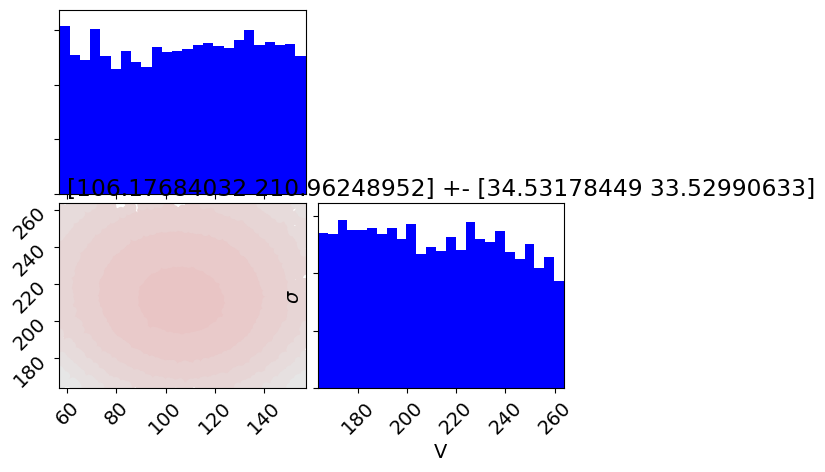

In [30]:
j0029_kinematics.ppxf_bin_spectra_test2()

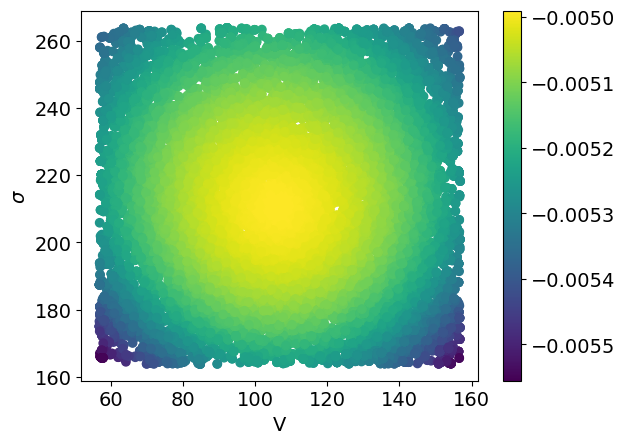

In [33]:
plt.scatter(j0029_kinematics.pars[:,0], j0029_kinematics.pars[:,1], c=j0029_kinematics.lnprobs)
plt.xlabel('V')
plt.ylabel(r'$\sigma$')
plt.colorbar()

In [184]:
j0029_kinematics.wave_range_templates

(2261.274110296115, 5805.867970660146)

In [185]:
print(j0029_kinematics.global_template_wave)

[2687.35776323 2687.50679972 2687.65584448 ... 4884.41932909 4884.69021104
 4884.96110801]


In [186]:
j0029_kinematics.wave_max

4300

In [187]:
j0029_kinematics.central_spectrum_ppxf.apoly.size

5215

In [188]:
np.concatenate((np.zeros(10),j0029_kinematics.central_spectrum_ppxf.apoly, np.zeros(5)))

array([0., 0., 0., ..., 0., 0., 0.])

In [189]:
j0029_kinematics.central_spectrum_ppxf.templates.shape

(10777, 150)

In [190]:
j0029_kinematics.central_spectrum_ppxf.lam.shape

(5215,)

In [191]:
j0029_kinematics.ppxf_bin_spectra_test2()

2117
2117
2117
4241 8476
4241 2301 2117
8659


ValueError: operands could not be broadcast together with shapes (10777,) (8659,) 

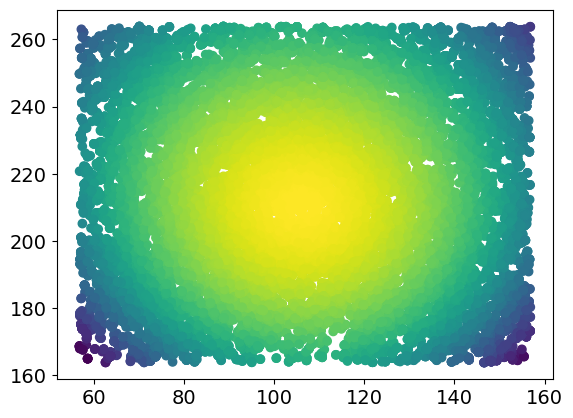

In [68]:
plt.scatter(j0029_kinematics.pars[:,0], j0029_kinematics.pars[:,1], c=j0029_kinematics.lnprobs)

In [73]:
j0029_kinematics.bin_kinematics

array([[1.06837597e+02, 2.13828031e+02, 4.85445264e+00, 5.31174104e+00,
        8.94332689e-02]])

____________________________

In [ ]:
j0029_kinematics.run_slacs_kcwi_kinematics(fit_poisson_noise=False, plot_bin_fits=False)

In [ ]:
questions = [29,
                30,
                31,
                32,
                35,
                42,
                56,
                75,
                90,
                94,
                95
            ]

In [ ]:
qs = j0029_kinematics.voronoi_binning_output[np.isin(j0029_kinematics.voronoi_binning_output[:,2], questions)]

In [ ]:
plt.imshow(j0029_kinematics.VD_2d, origin='lower')
plt.scatter(qs[:,0], qs[:,1], c=qs[:,2], cmap='sauron')
plt.colorbar()

In [ ]:
obj_names

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}SDSSJ0029-0055_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j0029_kinematics, file)

__________
# J0037

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ0037-0942'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.195 # lens redshift
T_exp = 1800*3 # This has been corrected
lens_center_x,lens_center_y = 59, 137
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


In [ ]:
j0037_kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j0037_kinematics.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [106,
                110,
                117,
                143,
                150,
                151,
                153,
                163,
                165
            ]

In [ ]:
qs = j0037_kinematics.voronoi_binning_output[np.isin(j0037_kinematics.voronoi_binning_output[:,2], questions)]

In [ ]:
plt.imshow(j0037_kinematics.VD_2d, origin='lower')
plt.scatter(qs[:,0], qs[:,1], c=qs[:,2], cmap='sauron')
plt.colorbar()

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j0037_kinematics, file)

# J0330

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ0330-0020'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.351 # lens redshift
#z_bs = 1.071 # background source redshift... additional piece for contamination
T_exp = 1800*6 # fixed
lens_center_x,lens_center_y = 59, 133
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
#------------------------------------------------------------------------------
# Kinematics systematics initial choices
# wavelength range
wave_min_j0330 = 3400
wave_max_j0330 = 4100 # shorter wave range because higher redshift
# degree of the additive Legendre polynomial in ppxf
degree_j0330 = 3 # 70/25 = 2.8 round up
#------------------------------------------------------------------------------
#KCWI mosaic datacube
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = f'{mos_dir}{obj_abbr}_background_source_mask.reg'


In [ ]:
j0330_kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min_j0330, # diff because higher redshift cuts off above 4100 A
                                             wave_max=wave_max_j0330,
                                             degree=degree_j0330,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
c = 299792.458 # km/s

In [ ]:
vel = 1000
plt.plot(j0330_kinematics.rest_wave[-1300:-600], j0330_kinematics.central_spectrum[-1300:-600], alpha=0.9, c='k')
plt.axvspan(3900, 4000, facecolor='black', alpha=0.5)
plt.plot(j0330_kinematics.rest_wave[-1300:-600]*(1+vel/c), j0330_kinematics.central_spectrum[-1300:-600], c='g', alpha=0.9)

In [ ]:
j0330_kinematics.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [6,
            7,
            14,
            15
            ]

In [ ]:
qs = j0330_kinematics.voronoi_binning_output[np.isin(j0330_kinematics.voronoi_binning_output[:,2], questions)]

In [ ]:
plt.imshow(j0330_kinematics.VD_2d, origin='lower')
plt.scatter(qs[:,0], qs[:,1], c=qs[:,2], cmap='sauron')
plt.colorbar()

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j0330_kinematics, file)

# J1112

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1112+0826'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.273 # lens redshift
z_bs = 0.629
T_exp = 1800*4 # this has been fixed.
lens_center_x,lens_center_y = 64, 131
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
j1112_kinematics = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1112_kinematics.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1112_kinematics, file)

# J1204

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1204+0358'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.164 # lens redshift
T_exp = 1800*4 # this has been corrected
lens_center_x,lens_center_y = 60, 135
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


In [ ]:
j1204= slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1204.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [30,
                36,
                43,
                47,
                48,
                49,
                50,
                51,
                53,
                54,
                55,
                69,
                81,
                89,
                111,
                120,
                129,
                133,
                141,
                149,
                150,
                151,
                153,
                154,
                155,
                156,
                157,
                158]

In [ ]:
qs = j1204.voronoi_binning_output[np.isin(j1204.voronoi_binning_output[:,2], questions)]

In [ ]:
q129 = j1204.voronoi_binning_output[j1204.voronoi_binning_output[:,2]==129]
q133 = j1204.voronoi_binning_output[j1204.voronoi_binning_output[:,2]==133]
q158 = j1204.voronoi_binning_output[j1204.voronoi_binning_output[:,2]==158]

In [ ]:
plt.imshow(j1204.VD_2d, origin='lower')
p=plt.scatter(qs[:,0], qs[:,1], c=qs[:,2], cmap='sauron', marker='.')
plt.scatter(q129[:,0], q129[:,1], c='k', marker='>')
plt.scatter(q133[:,0], q133[:,1], c='k', marker='x')
plt.scatter(q158[:,0], q158[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1204, file)

# J1250

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1250+0523'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.232 # lens redshift
T_exp = 1800*3 # this has been corrected
lens_center_x,lens_center_y = 53, 127
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


In [ ]:
j1250= slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1250.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [26,
                28,
                29,
                31,
                37,
                42,
                45,
                52,
                67,
                88,
                102,
                104,
                107,
                114,
                115,
                116
            ]

In [ ]:
qs = j1250.voronoi_binning_output[np.isin(j1250.voronoi_binning_output[:,2], questions)]
plt.imshow(j1250.VD_2d, origin='lower')
p=plt.scatter(qs[:,0], qs[:,1], c=qs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1250, file)

# J1306

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1306+0600'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.173 # lens redshift
T_exp = 1800*3 + 1500 # corrected #266 * 60
lens_center_x,lens_center_y = 56, 137
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'


In [ ]:
j1306= slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1306.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [7,
                16,
                17,
                23,
                24,
                30,
                31,
                36,
                57,
                61,
                72,
                78,
                89,
                96,
                97,
                99,
                104,
                106,
                107,
                108,
                109,
                110,
                111,
                113,
                114,
                115,
                116,
                117]

In [ ]:
bigger_questions = [24,
                    57,
                    61,
                    97,
                    107,
                    116]

In [ ]:
qs = j1306.voronoi_binning_output[np.isin(j1306.voronoi_binning_output[:,2], questions)]
bqs = j1306.voronoi_binning_output[np.isin(j1306.voronoi_binning_output[:,2], bigger_questions)]
plt.imshow(j1306.VD_2d, origin='lower')
p=plt.scatter(bqs[:,0], bqs[:,1], c=bqs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
# save it
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1306, file)

# J1402

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1402+6321'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.205 # lens redshift
T_exp = 1800*4 # corrected
lens_center_x,lens_center_y = 57, 129
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
j1402 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1402.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [46,
                51,
                53,
                54,
                59,
                66,
                68,
                80,
                83,
                86,
                92,
                95,
                99,
                108,
                150,
                151,
                152,
                153,
                159,
                162,
                168,
                173,
                176,
                177,
                178,
                179,
                180]
bigger_questions=[46,
                  51,
                  54,
                  83,
                  86,
                  92,
                  106,
                  108,
                  159,
                 162]
                                  
qs = j1402.voronoi_binning_output[np.isin(j1402.voronoi_binning_output[:,2], questions)]
bqs = j1402.voronoi_binning_output[np.isin(j1402.voronoi_binning_output[:,2], bigger_questions)]
plt.imshow(j1402.VD_2d, origin='lower')
p=plt.scatter(bqs[:,0], bqs[:,1], c=bqs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1402, file)

# Now J1402 with degree 5, to see if it improves the error wiggles.

In [ ]:
j1402.degree=5

In [ ]:
j1402.run_slacs_kcwi_kinematics(plot_bin_fits=True)

# J1531

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1531-0105'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.16 # lens redshift
T_exp = 1200*4 # corrected # I removed frame 32 which was 80 seconds... couldn't find center to make the mosiac... #+ 80*60 #266 * 60
lens_center_x,lens_center_y = 60, 129
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
j1531 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1531.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
questions = [6,
                7,
                18,
                20,
                24,
                25,
                26,
                29,
                30,
                35,
                43,
                49,
                58,
                59,
                61,
                62,
                66,
                67,
                68,
                69,
                70,
                71
            ]
bigger_questions = [25, 43, 59, 61, 62, 66, 67, 69]
                    

In [ ]:
qs = j1531.voronoi_binning_output[np.isin(j1531.voronoi_binning_output[:,2], questions)]
bqs = j1531.voronoi_binning_output[np.isin(j1531.voronoi_binning_output[:,2], bigger_questions)]
plt.imshow(j1531.VD_2d, origin='lower')
p=plt.scatter(bqs[:,0], bqs[:,1], c=bqs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1531, file)

# J1538

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1538+5817'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.143 # lens redshift
T_exp = 1800*2 # this has been corrected
lens_center_x,lens_center_y = 58, 119
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
j1538 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1538.run_slacs_kcwi_kinematics()

In [ ]:
j1538.ppxf_bin_spectra(plot_bin_fits=True)

In [ ]:
questions = [29,
                30,
                 32,
                33,
                37,
                38,
                43,
                46,
                48,
                50,
                54,
                56,
                58,
                69,
                74,
                77,
                78,
                79
                ]
bigger_questions = [29, 32, 33, 38, 50, 54]
qs = j1538.voronoi_binning_output[np.isin(j1538.voronoi_binning_output[:,2], questions)]
bqs = j1538.voronoi_binning_output[np.isin(j1538.voronoi_binning_output[:,2], bigger_questions)]
plt.imshow(j1538.VD_2d, origin='lower')
p=plt.scatter(bqs[:,0], bqs[:,1], c=bqs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
j1538.plot_kinematic_maps()

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1538, file)

In [ ]:
del j1204, j1250, j1306, j1402, j1531, j1538

# J1621

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1621+3931'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.245 # lens redshift
T_exp = 1200*6 # corrected
lens_center_x,lens_center_y = 58, 126 #30, 99
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
j1621 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1621.run_slacs_kcwi_kinematics()

In [ ]:
j1621.ppxf_bin_spectra(plot_bin_fits=True)

In [ ]:
questions = [20,
                22,
                23,
                25,
                26,
                27,
                28,
                38,
                40,
                47,
                51,
                57,
                63,
                66,
                68,
                69
            ]
bigger_questions = [25, 47, 63, 66]
qs = j1621.voronoi_binning_output[np.isin(j1621.voronoi_binning_output[:,2], questions)]
bqs = j1621.voronoi_binning_output[np.isin(j1621.voronoi_binning_output[:,2], bigger_questions)]
plt.imshow(j1621.VD_2d, origin='lower')
p=plt.scatter(bqs[:,0], bqs[:,1], c=bqs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
j1621.plot_kinematic_maps()

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1621, file)

# J1627

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1627-0053'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.208 # lens redshift
T_exp = 1800*5 + 960 # corrected #266 * 60
lens_center_x,lens_center_y = 56, 134
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
j1627 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1627.run_slacs_kcwi_kinematics()

In [ ]:
j1627.plot_kinematic_maps()

In [ ]:
j1627.ppxf_bin_spectra(plot_bin_fits=True)

In [ ]:
questions = [13,
                17,
                18,
                26,
                27,
                28,
                29,
                30,
                31,
                32,
                33,
                34,
                37,
                40,
                41,
                43,
                45,
                47,
                56,
                86,
                89,
                97,
                100,
                101,
                104,
                112,
                113,
                114,
                115,
                116,
                117,
                118,
                119,
                120,
                121,
                122,
                123,
                124,
                125
            ]
bigger_questions = [26, 31, 32, 33, 37, 43, 47, 56, 86, 122]
qs = j1627.voronoi_binning_output[np.isin(j1627.voronoi_binning_output[:,2], questions)]
bqs = j1627.voronoi_binning_output[np.isin(j1627.voronoi_binning_output[:,2], bigger_questions)]
plt.imshow(j1627.VD_2d, origin='lower')
p=plt.scatter(bqs[:,0], bqs[:,1], c=bqs[:,2], cmap='sauron', marker='.')
#plt.scatter(q142[:,0], q142[:,1], c='k', marker='x')
#plt.scatter(q145[:,0], q145[:,1], c='k', marker='+')
plt.colorbar(p)

In [ ]:
bin26

In [ ]:
j1627.VD_2d.shape

In [ ]:
bin26[0]

In [ ]:
j1627.VD_2d[bin26[0][0], bin26[0][1]]#, bin26[:,1]]

In [ ]:
j1627.VD_2d[16, 13]

In [ ]:
bin26

In [ ]:
a = j1627.VD_2d.copy()
for i in range(len(bin26)):
    a[bin26[i,0], bin26[i,1]] = 'nan'

In [ ]:
plt.imshow(a, origin='lower', cmap='sauron')
plt.colorbar()


In [ ]:
j1627.plot_kinematic_maps()

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1627, file)

# Try again at higher SN

In [ ]:
SN_hi = 25
j1627_hiSN = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN_hi,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1627_hiSN.run_slacs_kcwi_kinematics()

In [ ]:
plt.imshow(np.nansum(j1627_hiSN.cropped_datacube, axis=0), origin='lower')

In [ ]:
SN_mask = j1627_hiSN.SN_per_AA>2.5
plt.imshow(SN_mask, origin="lower", cmap='gray')
p=plt.imshow(j1627_hiSN.SN_per_AA, origin='lower', alpha=0.9)
plt.colorbar(p)

# 1/10/24 - Try rebinning the bad bins, load the pickle to make it faster.

In [ ]:
# open pickle
obj_name = obj_names[-3]
with open('/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/kinematics/2024_01_09/SDSSJ1627-0053_kinematics_2024_01_09.pkl', 'rb') as file:
    j1627 = pickle.load(file)

In [ ]:
# look at maps
j1627.plot_kinematic_maps()

In [ ]:
# get the highest velocity bin, it's the bad one
bad_bin = np.argmax(j1627.bin_kinematics[:,1])
bad_bin_spectrum = j1627.voronoi_binning_data[bad_bin]
bad_bin_pixels = j1627.voronoi_binning_output[j1627.voronoi_binning_output[:,2]==bad_bin][:,:2]
bad_bin_pixel_indices = np.argwhere(j1627.voronoi_binning_output[:,2]==bad_bin)
bad_bin_pixel_spectra = j1627.cropped_datacube[:,bad_bin_pixels[:,0].astype(int),bad_bin_pixels[:,1].astype(int)]

In [ ]:
# verify it's the right one
plt.imshow(j1627.VD_2d, origin='lower')
plt.scatter(bad_bin_pixels[:,0], bad_bin_pixels[:,1], c='k', marker='.')

In [ ]:
bad_bin_spectra

In [ ]:
bin_y_means = np.zeros(j1627.nbins)
bin_x_means = np.zeros(j1627.nbins)

for i in range(j1627.nbins):
    # get bins and x, y for each pixel
    bin_pixels = j1627.voronoi_binning_output[j1627.voronoi_binning_output[:,2]==i]
    bin_x = bin_pixels[:,0]# - j1627.radius_in_pixels # subtract 21 pixels to center at 0,0
    bin_y = bin_pixels[:,1]# - j1627.radius_in_pixels
    # calculate mean x and y
    mean_x = np.mean(bin_x)
    mean_y = np.mean(bin_y)
    # update array
    bin_x_means[i] = mean_x
    bin_y_means[i] = mean_y

# save bin centers in pixel coordinates
j1627.bin_centers = np.column_stack((bin_x_means, bin_y_means))

In [ ]:
# verify it's the right one
plt.imshow(j1627.VD_2d, origin='lower')
plt.scatter(bad_bin_pixels[:,0], bad_bin_pixels[:,1], c='k', marker='.')
# verify it's the right one
plt.scatter(j1627.bin_centers[:,0], j1627.bin_centers[:,1], c='k', marker='.', s=1)

In [ ]:
# identify the closest bin to each of the pixels in the bad bin
newbins = np.ones(len(bad_bin_pixels), dtype=int)

for i in range(len(bad_bin_pixels)):
    nearbin=0
    nearbin_distance=1000
    for j in range(j1627.nbins):
        if j!=bad_bin:
            bin_center = j1627.bin_centers[j]
            distance = np.sqrt( (bad_bin_pixels[i,0]-bin_center[0])**2 + (bad_bin_pixels[i,1]-bin_center[1])**2 )
            if distance < nearbin_distance:
                nearbin=j
                nearbin_distance=distance
    newbins[i] = nearbin
    
newbins

In [ ]:
new_binning[bad_bin_pixel_indices]

In [ ]:
# Fit these new bins with these pixels added to them
newbin_spectra = np.copy(j1627.voronoi_binning_data)
new_binning = np.copy(j1627.voronoi_binning_output)

for i in range(len(newbins)):
    new_bin = newbins[i]
    new_binning[bad_bin_pixel_indices[i],2] = new_bin
    newbin_index = np.unique(newbins)==new_bin
    new_newbin_pixel = bad_bin_pixels[i]
    pixel_spectrum = bad_bin_pixel_spectra[:,i]
    newbin_spectrum = newbin_spectra[new_bin]
    plt.plot(j1627.rest_wave, newbin_spectrum, c='k')
    newbin_spectrum += pixel_spectrum
    plt.plot(j1627.rest_wave, pixel_spectrum, c='b')
    plt.plot(j1627.rest_wave, newbin_spectrum, c='r')
    plt.xlim(j1627.wave_min, j1630.wave_max)
    plt.ylim(-0.1, 0.1)
    plt.pause(1)

In [ ]:
c = 299792.458 # km/s
import ppxf.ppxf_util as ppxf_util
from kcwi_util import find_nearest

def de_log_rebin(delog_axi, value, lin_axi):
    '''
    :param delog_axi: input the value by np.exp(logLam1)
    :param value: flux at the location of np.exp(logLam1) array
    :param lin_axi: linear space in wavelength that we want to intepolate
    :return: flux at the location of linear space in wavelength
    '''
    inte_sky = interpolate.interp1d(delog_axi, value, bounds_error=False)
    sky_lin = inte_sky(lin_axi)
    return sky_lin

In [ ]:
newbins

### new_bin_kinematics = np.copy(j1627.bin_kinematics)

for i, bin_spectrum in enumerate(newbin_spectra[np.unique(newbins)]):
    galaxy, log_wavelengths, velscale = ppxf_util.log_rebin(j1627.rest_wave_range, bin_spectrum)
    wavelengths = np.exp(log_wavelengths)

    galaxy = galaxy[wavelengths>j1627.wave_min] 
    background_source = j1627.background_spectrum.copy()
    background_source = background_source[wavelengths>j1627.wave_min]
    wavelengths = wavelengths[wavelengths>j1627.wave_min]
    galaxy = galaxy[wavelengths<j1627.wave_max]
    background_source = background_source[wavelengths<j1627.wave_max]
    wavelengths = wavelengths[wavelengths<j1627.wave_max]
    log_wavelengths = np.log(wavelengths)

    lam_range_global_temp = np.array([j1627.global_template_wave.min(), j1627.global_template_wave.max()])
    # after de-redshift, the initial redshift is zero.
    goodPixels = ppxf_util.determine_goodpixels(log_wavelengths, lam_range_global_temp, 0)

    ind_min = find_nearest(wavelengths, j1627.wave_min)
    ind_max = find_nearest(wavelengths, j1627.wave_max)
    mask=goodPixels[goodPixels<ind_max]
    mask = mask[mask>ind_min]
    boolen = ~((2956 < mask) & (mask < 2983))  # mask the Mg II
    mask = mask[boolen]
    boolen = ~((2983 < mask) & (mask < 3001))  # mask the Mg II
    mask = mask[boolen]
    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    vel = c*np.log(1 + 0)   # eq.(8) of Cappellari (2017)
    start = [vel, 250.]  # (km/s), starting guess for [V, sigma]
    bounds = [[-500, 500],[50, 450]]
    t = clock()

    noise = np.full_like(galaxy, 0.0047)

    pp = ppxf(j1627.global_template, 
              galaxy, 
              noise, 
              velscale, 
              start, 
              sky=background_source, 
              plot=False,#plot_bin_fits, 
              quiet=j1627.quiet,
                moments=2, 
              goodpixels=mask,
                degree=j1627.degree,
                velscale_ratio=j1627.velscale_ratio,
                lam=wavelengths,
                lam_temp=j1627.global_template_wave,
                )
    #plot the fit
    background = background_source * pp.weights[-1]
    data = pp.galaxy#spectrum_perpixel
    model = pp.bestfit
    log_axis = wavelengths
    lin_axis = np.linspace(j1627.wave_min, j1627.wave_max, data.size)
    back_lin = de_log_rebin(log_axis, background, lin_axis)
    model_lin = de_log_rebin(log_axis, model, lin_axis)
    data_lin = de_log_rebin(log_axis, data, lin_axis)
    noise_lin = data_lin - model_lin
    # find the indices of the restframe wavelengths that are closest to the min and max we want for plot limits
    plot_ind_min = find_nearest(lin_axis, j1627.wave_min)
    plot_ind_max = find_nearest(lin_axis, j1627.wave_max)
    # make the figure
    plt.figure(figsize=(8,6))
    plt.plot(lin_axis, data_lin, 'k-', label='data')
    plt.plot(lin_axis, model_lin, 'r-', label='model ('
                                                 'lens+background)')
    plt.plot(lin_axis, data_lin - back_lin, 'm-',
             label='remove background source from data', alpha=0.5)
    plt.plot(lin_axis, back_lin + np.full_like(back_lin, 0.9e-5), 'c-',label='background source', alpha=0.7)
    plt.plot(lin_axis, noise_lin + np.full_like(back_lin, 0.9e-5), 'g-',
             label='noise (data - best model)', alpha=0.7)
    plt.legend(loc='best')
    plt.ylim(np.nanmin(noise_lin[plot_ind_min:plot_ind_max])/1.1, np.nanmax(data_lin[plot_ind_min:plot_ind_max])*1.1)
    plt.xlim(j1627.wave_min, j1627.wave_max)
    plt.xlabel('wavelength (A)')
    plt.ylabel('relative flux')
    plt.title(f'Bin {np.unique(newbins)[i]} - Velocity dispersion - {int(pp.sol[1])} km/s')
    plt.show()
    plt.pause(1)
    
    new_bin_kinematics[np.unique(newbins)[i]] = np.hstack( (pp.sol[:2],
                                                           (pp.error*np.sqrt(pp.chi2))[:2],
                                                                      pp.chi2) 
                                                                      )
                                         

In [ ]:
VD_array    =np.zeros(j1627.voronoi_binning_output.shape[0])
dVD_array   =np.zeros(j1627.voronoi_binning_output.shape[0])
V_array     =np.zeros(j1627.voronoi_binning_output.shape[0])
dV_array    =np.zeros(j1627.voronoi_binning_output.shape[0])


for i in range(j1627.voronoi_binning_output.shape[0]):
    num=int(new_binning.T[2][i])
    vd = new_bin_kinematics[num][1]
    dvd = new_bin_kinematics[num][3]
    v = new_bin_kinematics[num][0]
    dv = new_bin_kinematics[num][2]

    VD_array[i]=vd
    dVD_array[i]=dvd
    V_array[i]=v
    dV_array[i]=dv

final=np.vstack((new_binning.T, VD_array, dVD_array, V_array, dV_array))

dim = j1627.radius_in_pixels*2+1

VD_2d=np.zeros((dim, dim))
VD_2d[:]=np.nan
for i in range(final.shape[1]):
    VD_2d[int(final[1][i])][int(final[0][i])]=final[3][i]

dVD_2d=np.zeros((dim, dim))
dVD_2d[:]=np.nan
for i in range(final.shape[1]):
    dVD_2d[int(final[1][i])][int(final[0][i])]=final[4][i]


V_2d=np.zeros((dim, dim))
V_2d[:]=np.nan
for i in range(final.shape[1]):
    V_2d[int(final[1][i])][int(final[0][i])]=final[5][i]

dV_2d=np.zeros((dim, dim))
dV_2d[:]=np.nan
for i in range(final.shape[1]):
    dV_2d[int(final[1][i])][int(final[0][i])]=final[6][i]

In [ ]:
plt.imshow(VD_2d, origin='lower', cmap='sauron')
plt.colorbar()

In [ ]:
plt.imshow(j1627.VD_2d, origin='lower', cmap='sauron')
plt.colorbar()

In [ ]:
j1627.datacube_visualization()

# Make a function for it

In [ ]:
def redistribute_bin (bin_number):
    
    bad_bin_spectrum = j1627.voronoi_binning_data[bin_number]
    bad_bin_pixels = j1627.voronoi_binning_output[j1627.voronoi_binning_output[:,2]==bin_number][:,:2]
    bad_bin_pixel_indices = np.argwhere(j1627.voronoi_binning_output[:,2]==bin_number)
    bad_bin_pixel_spectra = j1627.cropped_datacube[:,bad_bin_pixels[:,0].astype(int),bad_bin_pixels[:,1].astype(int)]

    # verify it's the right one
    plt.imshow(j1627.VD_2d, origin='lower', cmap='sauron')
    plt.colorbar()
    plt.title('VD')
    plt.scatter(bad_bin_pixels[:,0], bad_bin_pixels[:,1], c='k', marker='.', label='bin to be redistributed')
    plt.legend()
    plt.pause(1)
    
    # plot the ppxf fit
    galaxy, log_wavelengths, velscale = ppxf_util.log_rebin(j1627.rest_wave_range, bad_bin_spectrum)
    wavelengths = np.exp(log_wavelengths)

    galaxy = galaxy[wavelengths>j1627.wave_min] 
    background_source = j1627.background_spectrum.copy()
    background_source = background_source[wavelengths>j1627.wave_min]
    wavelengths = wavelengths[wavelengths>j1627.wave_min]
    galaxy = galaxy[wavelengths<j1627.wave_max]
    background_source = background_source[wavelengths<j1627.wave_max]
    wavelengths = wavelengths[wavelengths<j1627.wave_max]
    log_wavelengths = np.log(wavelengths)

    lam_range_global_temp = np.array([j1627.global_template_wave.min(), j1627.global_template_wave.max()])
    # after de-redshift, the initial redshift is zero.
    goodPixels = ppxf_util.determine_goodpixels(log_wavelengths, lam_range_global_temp, 0)

    ind_min = find_nearest(wavelengths, j1627.wave_min)
    ind_max = find_nearest(wavelengths, j1627.wave_max)
    mask=goodPixels[goodPixels<ind_max]
    mask = mask[mask>ind_min]
    boolen = ~((2956 < mask) & (mask < 2983))  # mask the Mg II
    mask = mask[boolen]
    boolen = ~((2983 < mask) & (mask < 3001))  # mask the Mg II
    mask = mask[boolen]
    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    vel = c*np.log(1 + 0)   # eq.(8) of Cappellari (2017)
    start = [vel, 250.]  # (km/s), starting guess for [V, sigma]
    bounds = [[-500, 500],[50, 450]]
    t = clock()

    noise = np.full_like(galaxy, 0.0047)

    pp = ppxf(j1627.global_template, 
              galaxy, 
              noise, 
              velscale, 
              start, 
              sky=background_source, 
              plot=False,#plot_bin_fits, 
              quiet=j1627.quiet,
                moments=2, 
              goodpixels=mask,
                degree=j1627.degree,
                velscale_ratio=j1627.velscale_ratio,
                lam=wavelengths,
                lam_temp=j1627.global_template_wave,
                )
    #plot the fit
    background = background_source * pp.weights[-1]
    data = pp.galaxy#spectrum_perpixel
    model = pp.bestfit
    log_axis = wavelengths
    lin_axis = np.linspace(j1627.wave_min, j1627.wave_max, data.size)
    back_lin = de_log_rebin(log_axis, background, lin_axis)
    model_lin = de_log_rebin(log_axis, model, lin_axis)
    data_lin = de_log_rebin(log_axis, data, lin_axis)
    noise_lin = data_lin - model_lin
    # find the indices of the restframe wavelengths that are closest to the min and max we want for plot limits
    plot_ind_min = find_nearest(lin_axis, j1627.wave_min)
    plot_ind_max = find_nearest(lin_axis, j1627.wave_max)
    # make the figure
    plt.figure(figsize=(8,6))
    plt.plot(lin_axis, data_lin, 'k-', label='data')
    plt.plot(lin_axis, model_lin, 'r-', label='model ('
                                                 'lens+background)')
    plt.plot(lin_axis, data_lin - back_lin, 'm-',
             label='remove background source from data', alpha=0.5)
    plt.plot(lin_axis, back_lin + np.full_like(back_lin, 0.9e-5), 'c-',label='background source', alpha=0.7)
    plt.plot(lin_axis, noise_lin + np.full_like(back_lin, 0.9e-5), 'g-',
             label='noise (data - best model)', alpha=0.7)
    plt.legend(loc='best')
    plt.ylim(np.nanmin(noise_lin[plot_ind_min:plot_ind_max])/1.1, np.nanmax(data_lin[plot_ind_min:plot_ind_max])*1.1)
    plt.xlim(j1627.wave_min, j1627.wave_max)
    plt.xlabel('wavelength (A)')
    plt.ylabel('relative flux')
    plt.title(f'Bin {bin_number} - Velocity dispersion - {int(pp.sol[1])} km/s')
    plt.show()
    plt.pause(1)

    # identify the closest bin to each of the pixels in the bad bin
    newbins = np.ones(len(bad_bin_pixels), dtype=int)

    for i in range(len(bad_bin_pixels)):
        nearbin=0
        nearbin_distance=1000
        for j in range(j1627.nbins):
            if j!=bad_bin:
                bin_center = j1627.bin_centers[j]
                distance = np.sqrt( (bad_bin_pixels[i,0]-bin_center[0])**2 + (bad_bin_pixels[i,1]-bin_center[1])**2 )
                if distance < nearbin_distance:
                    nearbin=j
                    nearbin_distance=distance
        newbins[i] = nearbin
    
    # Fit these new bins with these pixels added to them
    newbin_spectra = np.copy(j1627.voronoi_binning_data)
    new_binning = np.copy(j1627.voronoi_binning_output)

    for i in range(len(newbins)):
        new_bin = newbins[i]
        new_binning[bad_bin_pixel_indices[i],2] = new_bin
        newbin_index = np.unique(newbins)==new_bin
        new_newbin_pixel = bad_bin_pixels[i]
        pixel_spectrum = bad_bin_pixel_spectra[:,i]
        newbin_spectrum = newbin_spectra[new_bin]
        plt.plot(j1627.rest_wave, newbin_spectrum, c='k')
        newbin_spectrum += pixel_spectrum
        plt.plot(j1627.rest_wave, pixel_spectrum, c='b')
        plt.plot(j1627.rest_wave, newbin_spectrum, c='r')
        plt.xlim(j1627.wave_min, j1630.wave_max)
        plt.ylim(-0.1, 0.1)
        plt.title(f'Pixel from bin {bin_number} added to bin {new_bin}')
        plt.pause(1)

    new_bin_kinematics = np.copy(j1627.bin_kinematics)

    for i, bin_spectrum in enumerate(newbin_spectra[np.unique(newbins)]):
        galaxy, log_wavelengths, velscale = ppxf_util.log_rebin(j1627.rest_wave_range, bin_spectrum)
        wavelengths = np.exp(log_wavelengths)

        galaxy = galaxy[wavelengths>j1627.wave_min] 
        background_source = j1627.background_spectrum.copy()
        background_source = background_source[wavelengths>j1627.wave_min]
        wavelengths = wavelengths[wavelengths>j1627.wave_min]
        galaxy = galaxy[wavelengths<j1627.wave_max]
        background_source = background_source[wavelengths<j1627.wave_max]
        wavelengths = wavelengths[wavelengths<j1627.wave_max]
        log_wavelengths = np.log(wavelengths)

        lam_range_global_temp = np.array([j1627.global_template_wave.min(), j1627.global_template_wave.max()])
        # after de-redshift, the initial redshift is zero.
        goodPixels = ppxf_util.determine_goodpixels(log_wavelengths, lam_range_global_temp, 0)

        ind_min = find_nearest(wavelengths, j1627.wave_min)
        ind_max = find_nearest(wavelengths, j1627.wave_max)
        mask=goodPixels[goodPixels<ind_max]
        mask = mask[mask>ind_min]
        boolen = ~((2956 < mask) & (mask < 2983))  # mask the Mg II
        mask = mask[boolen]
        boolen = ~((2983 < mask) & (mask < 3001))  # mask the Mg II
        mask = mask[boolen]
        # Here the actual fit starts. The best fit is plotted on the screen.
        # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
        #
        vel = c*np.log(1 + 0)   # eq.(8) of Cappellari (2017)
        start = [vel, 250.]  # (km/s), starting guess for [V, sigma]
        bounds = [[-500, 500],[50, 450]]
        t = clock()

        noise = np.full_like(galaxy, 0.0047)

        pp = ppxf(j1627.global_template, 
                  galaxy, 
                  noise, 
                  velscale, 
                  start, 
                  sky=background_source, 
                  plot=False,#plot_bin_fits, 
                  quiet=j1627.quiet,
                    moments=2, 
                  goodpixels=mask,
                    degree=j1627.degree,
                    velscale_ratio=j1627.velscale_ratio,
                    lam=wavelengths,
                    lam_temp=j1627.global_template_wave,
                    )
        #plot the fit
        background = background_source * pp.weights[-1]
        data = pp.galaxy#spectrum_perpixel
        model = pp.bestfit
        log_axis = wavelengths
        lin_axis = np.linspace(j1627.wave_min, j1627.wave_max, data.size)
        back_lin = de_log_rebin(log_axis, background, lin_axis)
        model_lin = de_log_rebin(log_axis, model, lin_axis)
        data_lin = de_log_rebin(log_axis, data, lin_axis)
        noise_lin = data_lin - model_lin
        # find the indices of the restframe wavelengths that are closest to the min and max we want for plot limits
        plot_ind_min = find_nearest(lin_axis, j1627.wave_min)
        plot_ind_max = find_nearest(lin_axis, j1627.wave_max)
        # make the figure
        plt.figure(figsize=(8,6))
        plt.plot(lin_axis, data_lin, 'k-', label='data')
        plt.plot(lin_axis, model_lin, 'r-', label='model ('
                                                     'lens+background)')
        plt.plot(lin_axis, data_lin - back_lin, 'm-',
                 label='remove background source from data', alpha=0.5)
        plt.plot(lin_axis, back_lin + np.full_like(back_lin, 0.9e-5), 'c-',label='background source', alpha=0.7)
        plt.plot(lin_axis, noise_lin + np.full_like(back_lin, 0.9e-5), 'g-',
                 label='noise (data - best model)', alpha=0.7)
        plt.legend(loc='best')
        plt.ylim(np.nanmin(noise_lin[plot_ind_min:plot_ind_max])/1.1, np.nanmax(data_lin[plot_ind_min:plot_ind_max])*1.1)
        plt.xlim(j1627.wave_min, j1627.wave_max)
        plt.xlabel('wavelength (A)')
        plt.ylabel('relative flux')
        plt.title(f'Bin {np.unique(newbins)[i]} - Velocity dispersion - {int(pp.sol[1])} km/s')
        plt.show()
        plt.pause(1)

        new_bin_kinematics[np.unique(newbins)[i]] = np.hstack( (pp.sol[:2],
                                                               (pp.error*np.sqrt(pp.chi2))[:2],
                                                                          pp.chi2) 
                                                                          )

    VD_array    =np.zeros(j1627.voronoi_binning_output.shape[0])
    dVD_array   =np.zeros(j1627.voronoi_binning_output.shape[0])
    V_array     =np.zeros(j1627.voronoi_binning_output.shape[0])
    dV_array    =np.zeros(j1627.voronoi_binning_output.shape[0])


    for i in range(j1627.voronoi_binning_output.shape[0]):
        num=int(new_binning.T[2][i])
        vd = new_bin_kinematics[num][1]
        dvd = new_bin_kinematics[num][3]
        v = new_bin_kinematics[num][0]
        dv = new_bin_kinematics[num][2]

        VD_array[i]=vd
        dVD_array[i]=dvd
        V_array[i]=v
        dV_array[i]=dv

    final=np.vstack((new_binning.T, VD_array, dVD_array, V_array, dV_array))

    dim = j1627.radius_in_pixels*2+1

    VD_2d=np.zeros((dim, dim))
    VD_2d[:]=np.nan
    for i in range(final.shape[1]):
        VD_2d[int(final[1][i])][int(final[0][i])]=final[3][i]

    dVD_2d=np.zeros((dim, dim))
    dVD_2d[:]=np.nan
    for i in range(final.shape[1]):
        dVD_2d[int(final[1][i])][int(final[0][i])]=final[4][i]


    V_2d=np.zeros((dim, dim))
    V_2d[:]=np.nan
    for i in range(final.shape[1]):
        V_2d[int(final[1][i])][int(final[0][i])]=final[5][i]

    dV_2d=np.zeros((dim, dim))
    dV_2d[:]=np.nan
    for i in range(final.shape[1]):
        dV_2d[int(final[1][i])][int(final[0][i])]=final[6][i]

    plt.imshow(VD_2d, origin='lower', cmap='sauron')
    plt.colorbar()
    plt.title('New VD map')
    plt.pause(1)

    plt.imshow(j1627.VD_2d, origin='lower', cmap='sauron')
    plt.colorbar()
    plt.title('Old VD map')
    plt.pause(1)

In [ ]:
redistribute_bin(33)

# J1630

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ1630+4520'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.248 # lens redshift
T_exp = 1800*4 + 1180 #266 * 60
lens_center_x,lens_center_y = 59, 131
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
j1630 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j1630.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j1630, file)

In [ ]:
j1630.ppxf_bin_spectra(plot_bin_fits=True)

# J2303

In [ ]:
# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ2303+1422'
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = 0.155 # lens redshift
T_exp = 1800*3 # corrected
lens_center_x,lens_center_y = 58, 124
# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
background_spectrum_file = None#f'{mos_dir}{obj_abbr}_spectrum_background_source.fits'
background_source_mask_file = None#f'{mos_dir}{obj_abbr}_background_source_mask.reg'

In [ ]:
zlens=z

In [ ]:
j2303 = slacs_kcwi_kinematics(
                                             mos_dir=mos_dir,
                                             kin_dir=kin_dir,
                                             obj_name=obj_name,
                                             kcwi_datacube_file=kcwi_datacube,
                                             central_spectrum_file=central_spectrum_file,
                                             background_spectrum_file=None,
                                             background_source_mask_file=background_source_mask_file,
                                             zlens=zlens,
                                             exp_time=T_exp,
                                             lens_center_x=lens_center_x,
                                             lens_center_y=lens_center_y,
                                             aperture=aperture,
                                             wave_min=wave_min,
                                             wave_max=wave_max,
                                             degree=degree,
                                             sps_name=sps_name,
                                             pixel_scale=kcwi_scale,
                                             FWHM=FWHM,
                                             noise=noise,
                                             velscale_ratio=velscale_ratio,
                                             radius_in_pixels=radius_in_pixels,
                                             SN=SN,
                                             plot=True,
                                             quiet=False
)

In [ ]:
j2303.run_slacs_kcwi_kinematics(plot_bin_fits=False)

In [ ]:
# to save as a pickle
with open(f'{kinematics_dir}{obj_name}_kinematics_{date}.pkl', 'wb') as file:
    pickle.dump(j2303, file)